In [34]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import top_k_accuracy_score

In [ ]:
df = pd.read_csv('./data/processed/post_list_endgame.csv')
df.head()

Unnamed: 0    imdb_id  Action  Adventure  Animation  Comedy  Crime  \
0           0  tt0113228       0          0          0       1      0   
1           1  tt0113228       0          0          0       1      0   
2           2  tt0114885       0          0          0       1      0   
3           3  tt0114885       0          0          0       1      0   
4           4  tt0114885       0          0          0       1      0   

   Documentary  Drama  Family  ...  loudness  mode  speechiness  acousticness  \
0            0      0       0  ...    -8.096     0       0.0271       0.06430   
1            0      0       0  ...   -11.271     1       0.0703       0.83000   
2            0      1       0  ...    -6.362     1       0.0746       0.60000   
3            0      1       0  ...    -8.598     0       0.0307       0.00233   
4            0      1       0  ...    -2.541     1       0.0361       0.63900   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0           0.00062    0.5040    0.518  143.038       141440               4  
1           0.00000    0.4940    0.659  135.100       144680               4  
2           0.03470    0.0461    0.386  137.635       284120               4  
3           0.00700    0.1110    0.472  179.851       268200               4  
4           0.00000    0.1710    0.762  117.991       199240               4  

[5 rows x 40 columns]

In [11]:
genre_cols = [
    'Action','Adventure','Animation','Comedy','Crime','Documentary','Drama',
    'Family','Fantasy','Foreign','History','Horror','Music','Mystery',
    'Romance','Science Fiction','Thriller','Western'
]

feature_cols = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
# feature_cols = ['loudness','acousticness','danceability','energy','tempo','valence']

In [ ]:
X = df[feature_cols]
y = df[genre_cols]
y = np.argmax(y.values, axis=1)

In [13]:

class_counts = pd.Series(y).value_counts().sort_index()
pd.DataFrame({
    "genre": genre_cols,
    "count": class_counts.values
})


genre  count
0            Action   3479
1         Adventure   1032
2         Animation    581
3            Comedy   9627
4             Crime   1300
5       Documentary   1838
6             Drama   6444
7            Family     91
8           Fantasy     68
9           Foreign     24
10          History     19
11           Horror    690
12            Music    201
13          Mystery     98
14          Romance     76
15  Science Fiction     40
16         Thriller    166
17          Western     45

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)
X_tr, X_eval, y_tr, y_eval = train_test_split(X_train, y_train, test_size=0.2,random_state=42, stratify=y_train)

In [ ]:
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=20,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    tree_method="hist"
)

xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_eval, y_eval)],
    verbose=50
)

y_val_pred = xgb_model.predict(X_eval)
y_val_proba = xgb_model.predict_proba(X_eval)

print("XGB Val Accuracy:", accuracy_score(y_eval, y_val_pred))
print("XGB Val F1(macro):", f1_score(y_eval, y_val_pred, average="macro"))


[0]	validation_0-mlogloss:2.65875
[50]	validation_0-mlogloss:1.87222
[100]	validation_0-mlogloss:1.79597
[150]	validation_0-mlogloss:1.79121
[200]	validation_0-mlogloss:1.80144
[250]	validation_0-mlogloss:1.81477
[300]	validation_0-mlogloss:1.83056
[350]	validation_0-mlogloss:1.84600
[399]	validation_0-mlogloss:1.86195
XGB Val Accuracy: 0.373759380295328
XGB Val F1(macro): 0.12324481591239797


In [ ]:
lgb_model = LGBMClassifier(
    objective="multiclass",
    num_class=20,
    n_estimators=700,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight="balanced",
    random_state=42
)

lgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_eval, y_eval)],
    eval_metric="multi_logloss"
)

y_eval_pred = lgb_model.predict(X_eval)
y_eval_proba = lgb_model.predict_proba(X_eval)

print("LGBM Val Accuracy:", accuracy_score(y_eval, y_eval_pred))
print("LGBM Val F1(macro):", f1_score(y_eval, y_eval_pred, average="macro"))

# LGBM Val Accuracy: 0.28927620430888407
# LGBM Val F1(macro): 0.12763928065977248



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 16524, number of used features: 13
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM

---

최고 성능 방법 탐색

In [ ]:
lgb_best = None
best_f1 = 0

for _ in range(20):
    model = LGBMClassifier(
        objective="multiclass",                             # 다중분류
        num_class=len(set(y_tr)),                           # 클래스 수 -> 멀티클래스일때 명시적으로 알려줘야함
        n_estimators=random.choice([400, 600, 800, 1000]),  
        learning_rate=random.choice([0.01, 0.03, 0.05]),
        num_leaves=random.choice([31, 64, 128]),            # 최대 leaf 수 : 모델 복잡도 조절
        min_child_samples=random.choice([10, 20, 30]),      # 최소 샘플수 : 과적합방지
        subsample=random.choice([0.8, 0.9, 1.0]),           # 각 트리 학습에 사용하는 대이터 비율
        colsample_bytree=random.choice([0.8, 0.9, 1.0]),    # 각 트리에서 사용하는 피처 비율
        class_weight="balanced",                            # 장르 불균형 보정
        random_state=42
    )

    model.fit(X_tr, y_tr)
    pred = model.predict(X_eval)
    f1 = f1_score(y_eval, pred, average="macro")

    if f1 > best_f1:
        best_f1 = f1
        lgb_best = model

print("Best LGBM Val F1:", best_f1)

# Best LGBM Val F1: 0.12845383334707158

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 16524, number of used features: 13
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM

In [ ]:
xgb_best = None
best_f1 = 0

for _ in range(20):
    model = XGBClassifier(
        objective="multi:softprob",                         # 다중분류 + 클래스별 확률 출력
        num_class=len(set(y_tr)),
        n_estimators=random.choice([300, 500, 700]),
        learning_rate=random.choice([0.03, 0.05, 0.1]),
        max_depth=random.choice([4, 6, 8]),
        subsample=random.choice([0.8, 0.9, 1.0]),
        colsample_bytree=random.choice([0.8, 0.9, 1.0]),
        eval_metric="mlogloss",                             # 다중분류용 손실 함수
        tree_method="hist",                                 # 히스토그램 기반 학습 : 속도 게선
        random_state=42
    )

    model.fit(X_tr, y_tr)
    pred = model.predict(X_eval)
    f1 = f1_score(y_eval, pred, average="macro")

    if f1 > best_f1:
        best_f1 = f1
        xgb_best = model

print("Best XGB Val F1:", best_f1)


Best XGB Val F1: 0.1298078366201178


In [ ]:
# def top_k_accuracy(y_true, y_proba, k=3):
#     top_k = np.argsort(y_proba, axis=1)[:, -k:]
#     return np.mean([y_true[i] in top_k[i] for i in range(len(y_true))])

In [37]:
results = []

for name, model in [("XGB", xgb_best), ("LGBM", lgb_best)]:
    proba = model.predict_proba(X_eval)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_eval, model.predict(X_eval)),
        "F1_macro": f1_score(y_eval, model.predict(X_eval), average="macro"),
        "Top3": top_k_accuracy_score(y_eval, proba, k=3),
        "Top5": top_k_accuracy_score(y_eval, proba, k=5)
    })


In [39]:
lgb_proba = lgb_best.predict_proba(X_eval)

print("Accuracy:", accuracy_score(y_eval, lgb_best.predict(X_eval)))
print("Top-3 Accuracy:", top_k_accuracy_score(y_eval, lgb_proba, k=3))
print("Top-5 Accuracy:", top_k_accuracy_score(y_eval, lgb_proba, k=5))


Accuracy: 0.28733962720890827
Top-3 Accuracy: 0.7078189300411523
Top-5 Accuracy: 0.8738804163640765


In [40]:
xgb_proba = xgb_best.predict_proba(X_eval)

print("Accuracy:", accuracy_score(y_eval, xgb_best.predict(X_eval)))
print("Top-3 Accuracy:", top_k_accuracy_score(y_eval, xgb_proba, k=3))
print("Top-5 Accuracy:", top_k_accuracy_score(y_eval, xgb_proba, k=5))

Accuracy: 0.3628661341079642
Top-3 Accuracy: 0.747518760590656
Top-5 Accuracy: 0.8804163640764948


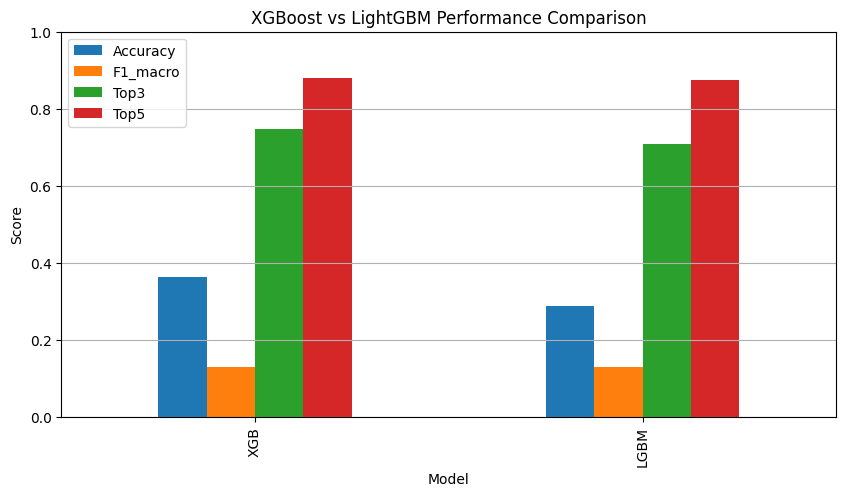

In [41]:
import matplotlib.pyplot as plt

df = pd.DataFrame(results).set_index("Model")
df.plot(kind="bar", figsize=(10, 5))
plt.title("XGBoost vs LightGBM Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()

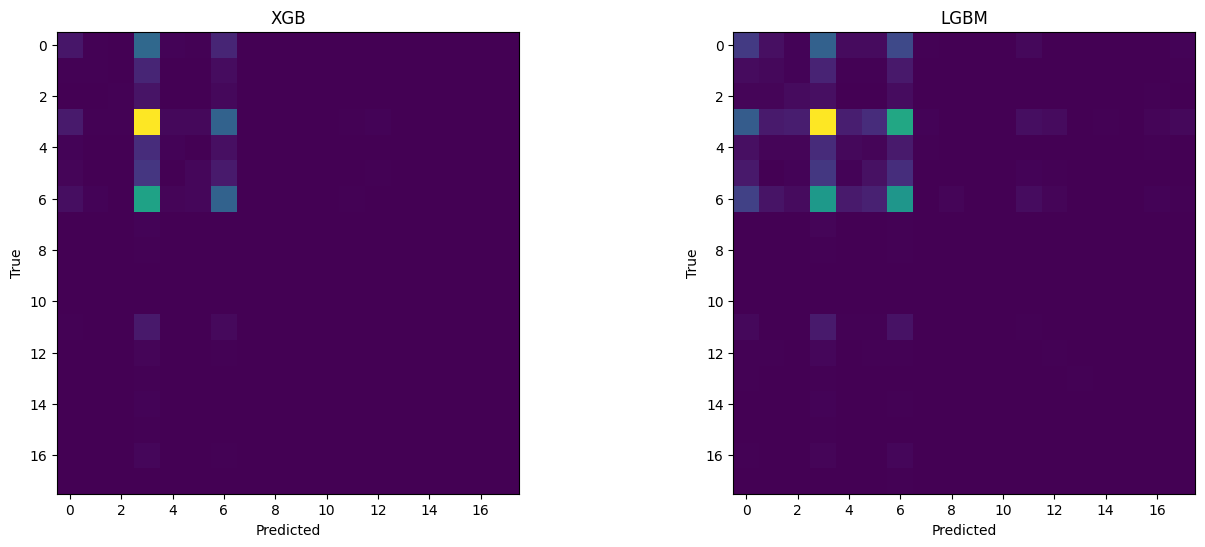

In [42]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (name, model) in zip(axes, [("XGB", xgb_best), ("LGBM", lgb_best)]):
    cm = confusion_matrix(y_eval, model.predict(X_eval))
    ax.imshow(cm)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.show()


소수의 클래스만 계속 예측 => 클래스 불균형 or 라벨 수 대비 데이터 수 부족

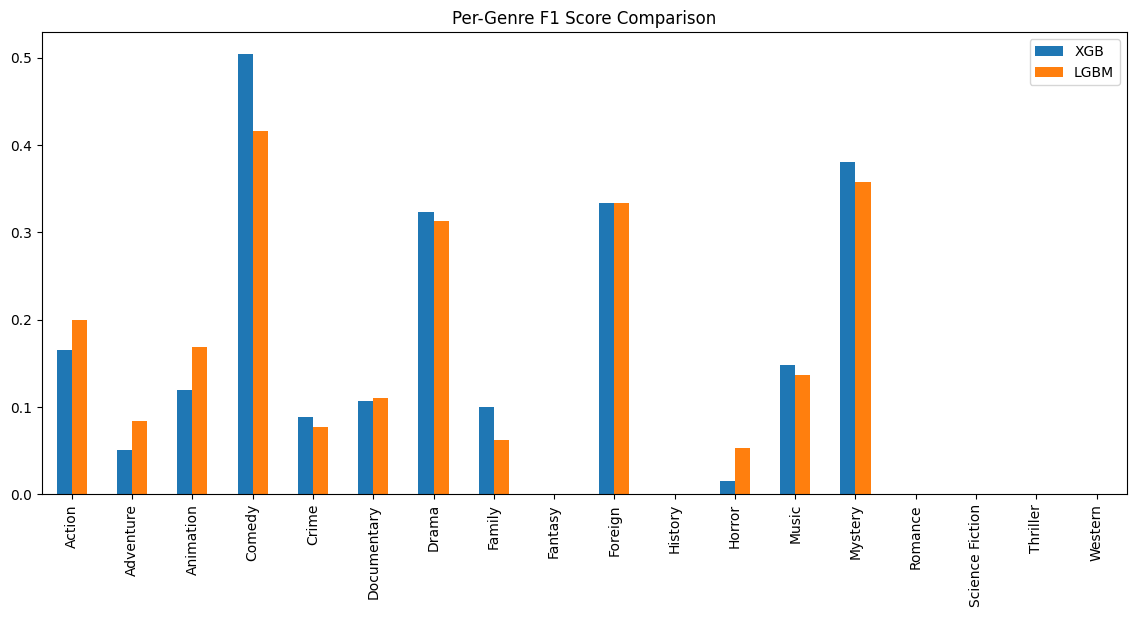

In [43]:
from sklearn.metrics import f1_score

f1_xgb = f1_score(y_eval, xgb_best.predict(X_eval), average=None)
f1_lgb = f1_score(y_eval, lgb_best.predict(X_eval), average=None)

df_f1 = pd.DataFrame({
    "XGB": f1_xgb,
    "LGBM": f1_lgb
}, index=genre_cols[:len(f1_xgb)])

df_f1.plot(kind="bar", figsize=(14, 6))
plt.title("Per-Genre F1 Score Comparison")
plt.show()


---

XGBoost 성능 시각화

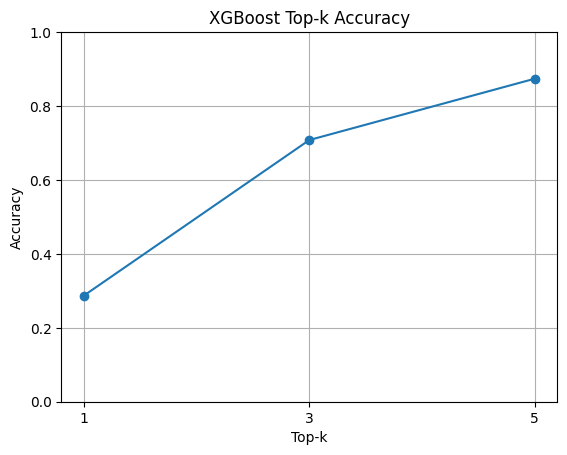

In [ ]:
# top-k accuracy
topk = [1, 3, 5]
accuracy = [0.287, 0.708, 0.874]

plt.figure()
plt.plot(topk, accuracy, marker='o')
plt.xticks(topk)
plt.ylim(0, 1)
plt.xlabel("Top-k")
plt.ylabel("Accuracy")
plt.title("XGBoost Top-k Accuracy")
plt.grid()
plt.show()

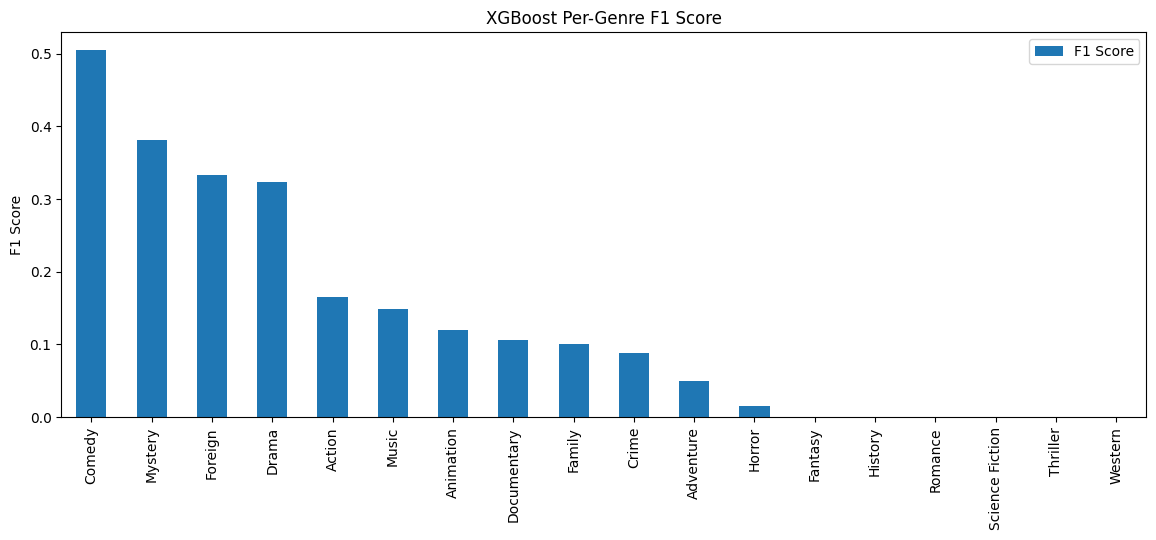

In [ ]:
# 장르별 f1 score
f1_per_genre = f1_score(
    y_eval,
    xgb_best.predict(X_eval),
    average=None
)

df_genre_f1 = pd.DataFrame({
    "F1 Score": f1_per_genre
}, index=genre_cols[:len(f1_per_genre)])

df_genre_f1.sort_values("F1 Score", ascending=False).plot(kind="bar", figsize=(14, 5))
plt.title("XGBoost Per-Genre F1 Score")
plt.ylabel("F1 Score")
plt.show()


---

테스트 데이터 넣어보기

In [114]:
test_data = pd.read_csv('./data/song_track.csv')

test_song = test_data.iloc[268:273]
titles = test_data.iloc[268:273]['track_name'].values
artist = test_data.iloc[268:273]['artist_name'].values
test_song

genre   artist_name           track_name                track_id  \
268   R&B      Annmarie            Handle It  4WZuRY0CLNJg8P9OFBStEN   
269   R&B  Jason Derulo              It Girl  4fINc8dnfcz7AdhFYVA4i7   
270   R&B   James Blake          Assume Form  6cJrQc34txUzXd90xWEAOh   
271   R&B        T-Pain    Keep This from Me  3FtIrPWVEot7KxCo97S1UY   
272   R&B   Chris Brown  Grass Ain't Greener  6DaE3A1uIvDqVrVSNvUy6B   

     popularity  acousticness  danceability  duration_ms  energy  \
268          60        0.7170         0.649       195254   0.646   
269          71        0.0165         0.668       192200   0.718   
270          65        0.8860         0.413       289600   0.349   
271          53        0.0871         0.510       147376   0.626   
272          67        0.3880         0.644       201422   0.601   

     instrumentalness key  liveness  loudness   mode  speechiness    tempo  \
268          0.000018   B    0.0931    -6.051  Major       0.0438  117.953   
269          0.000000  C#    0.1040    -4.736  Minor       0.0605   91.993   
270          0.000195   E    0.0910   -10.361  Minor       0.0628  139.274   
271          0.000000  C#    0.2630    -6.150  Minor       0.3320   80.795   
272          0.000000  A#    0.0884    -5.097  Minor       0.0496  133.946   

    time_signature  valence  
268            4/4    0.528  
269            4/4    0.345  
270            4/4    0.148  
271            4/4    0.516  
272            4/4    0.518

In [115]:
X_test_songs = test_song[feature_cols]
X_test_songs

danceability  energy key  loudness   mode  speechiness  acousticness  \
268         0.649   0.646   B    -6.051  Major       0.0438        0.7170   
269         0.668   0.718  C#    -4.736  Minor       0.0605        0.0165   
270         0.413   0.349   E   -10.361  Minor       0.0628        0.8860   
271         0.510   0.626  C#    -6.150  Minor       0.3320        0.0871   
272         0.644   0.601  A#    -5.097  Minor       0.0496        0.3880   

     instrumentalness  liveness  valence    tempo  duration_ms time_signature  
268          0.000018    0.0931    0.528  117.953       195254            4/4  
269          0.000000    0.1040    0.345   91.993       192200            4/4  
270          0.000195    0.0910    0.148  139.274       289600            4/4  
271          0.000000    0.2630    0.516   80.795       147376            4/4  
272          0.000000    0.0884    0.518  133.946       201422            4/4

In [116]:
X_test_songs['key'] = X_test_songs['key'].map({
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5,
    'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11
})

X_test_songs['mode'] = X_test_songs['mode'].map({'Minor': 0, 'Major': 1})
X_test_songs['time_signature'] = X_test_songs['time_signature'].str.split('/').str[0].astype(int)

X_test_songs = X_test_songs.apply(pd.to_numeric, errors='coerce')


/var/folders/6y/jlc663td38l8vmmfxj4l26z40000gn/T/ipykernel_67145/1724209821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_songs['key'] = X_test_songs['key'].map({
/var/folders/6y/jlc663td38l8vmmfxj4l26z40000gn/T/ipykernel_67145/1724209821.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_songs['mode'] = X_test_songs['mode'].map({'Minor': 0, 'Major': 1})
/var/folders/6y/jlc663td38l8vmmfxj4l26z40000gn/T/ipykernel_67145/1724209821.py:7: SettingWithCopyWarning: 
A value is trying to be set

In [117]:
X_test_songs = X_test_songs.astype(float)

In [118]:
def get_top5_proba(model, X_row, genre_cols):
    proba = model.predict_proba(X_row)[0]
    top_idx = np.argsort(proba)[::-1][:5]

    return pd.DataFrame({
        "Genre": [genre_cols[i] for i in top_idx],
        "Probability": proba[top_idx]
    })

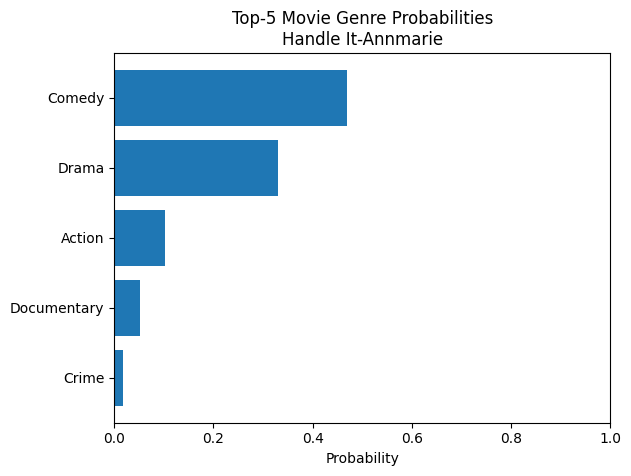

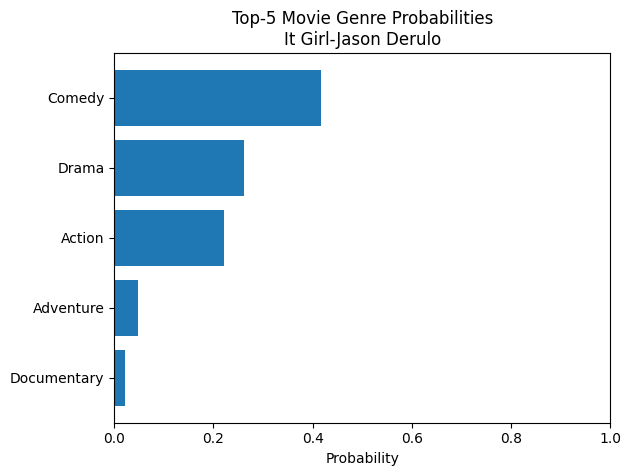

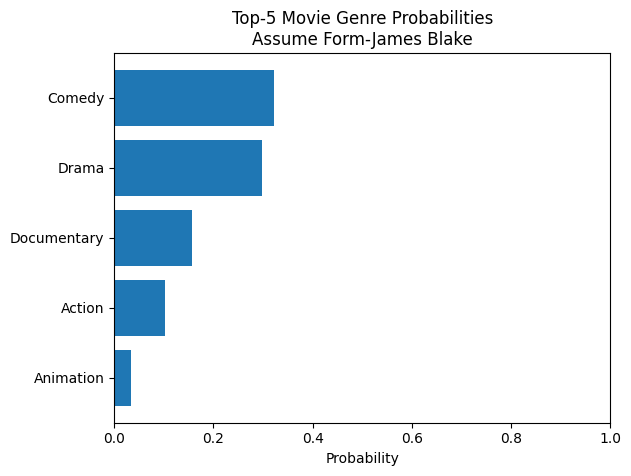

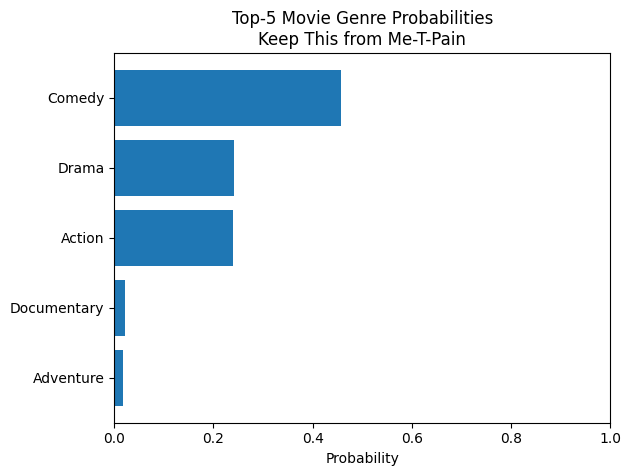

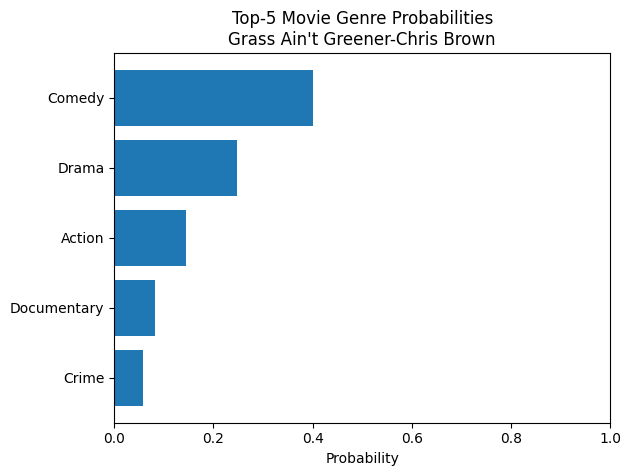

In [119]:
for i in range(len(X_test_songs)):
    df_proba = get_top5_proba(
        xgb_best,
        X_test_songs.iloc[[i]],
        genre_cols
    )

    plt.figure()
    plt.barh(
        df_proba["Genre"],
        df_proba["Probability"]
    )
    plt.gca().invert_yaxis()
    plt.title(f"Top-5 Movie Genre Probabilities\n{titles[i]}-{artist[i]}")
    plt.xlabel("Probability")
    plt.xlim(0, 1)
    plt.show()

---

모델 저장

In [90]:
import joblib

joblib.dump({
    "model": xgb_best,
    "feature_cols": feature_cols,
    "genre_cols": genre_cols
}, "ost_classifier_xgb.joblib")

['ost_classifier_xgb.joblib']